In [1]:
import keras
from keras.models import Sequential
from keras.applications.resnet_v2 import ResNet101V2
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train_2.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
24136,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
24137,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
24138,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
24139,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
24140,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame2/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 24141/24141 [03:25<00:00, 117.39it/s]


In [4]:
# converting the list to numpy array
X = np.array(train_image,np.float16)
train_image=[]
# shape of the array
X.shape

(24141, 224, 224, 3)

In [5]:
# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [6]:
X=[]
y=[]

In [7]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 224, 224, 3)
(4829, 224, 224, 3)
(19312, 51)
(4829, 51)


In [9]:
# creating the base model of pre-trained ResNet101V2 model
base_model = ResNet101V2(weights='imagenet', include_top=False)

In [10]:
print(base_model.output_shape)

(None, None, None, 2048)


In [11]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

__________________________________________________________________________________________________
conv3_block4_1_relu (Activation (None, None, None, 1 0           conv3_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_2_pad (ZeroPadding (None, None, None, 1 0           conv3_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_conv (Conv2D)    (None, None, None, 1 147456      conv3_block4_2_pad[0][0]         
__________________________________________________________________________________________________
conv3_block4_2_bn (BatchNormali (None, None, None, 1 512         conv3_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_2_relu (Activation (None, None, None, 1 0           conv3_block4_2_bn[0][0]          
__________

conv4_block7_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block7_1_relu (Activation (None, None, None, 2 0           conv4_block7_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block7_2_pad (ZeroPadding (None, None, None, 2 0           conv4_block7_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block7_2_conv (Conv2D)    (None, None, None, 2 589824      conv4_block7_2_pad[0][0]         
__________________________________________________________________________________________________
conv4_block7_2_bn (BatchNormali (None, None, None, 2 1024        conv4_block7_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block14_2_pad (ZeroPaddin (None, None, None, 2 0           conv4_block14_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block14_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block14_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block14_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block14_2_relu (Activatio (None, None, None, 2 0           conv4_block14_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block14_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block14_2_relu[0][0]       
__________

conv4_block21_2_conv (Conv2D)   (None, None, None, 2 589824      conv4_block21_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block21_2_bn (BatchNormal (None, None, None, 2 1024        conv4_block21_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block21_2_relu (Activatio (None, None, None, 2 0           conv4_block21_2_bn[0][0]         
__________________________________________________________________________________________________
conv4_block21_3_conv (Conv2D)   (None, None, None, 1 263168      conv4_block21_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block21_out (Add)         (None, None, None, 1 0           conv4_block20_out[0][0]          
                                                                 conv4_block21_3_conv[0][0]       
__________

In [12]:
base_model.get_config()

{'name': 'resnet101v2',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'conv1_pad',
   'class_name': 'ZeroPadding2D',
   'config': {'name': 'conv1_pad',
    'trainable': True,
    'dtype': 'float32',
    'padding': ((3, 3), (3, 3)),
    'data_format': 'channels_last'},
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'name': 'conv1_conv',
   'class_name': 'Conv2D',
   'config': {'name': 'conv1_conv',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (7, 7),
    'strides': (2, 2),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed'

t1=datetime.datetime.now()
print(t1)
# extracting features for training frames
X_train = base_model.predict(X_train)
print(X_train.shape)
t2=datetime.datetime.now()
print(t2)

# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(19312, 7*7*2048)

# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/ResNet101V2_X_train_2.pkl') 

t3=datetime.datetime.now()
print(t3)
# extracting features for validation frames
X_test = base_model.predict(X_test)
print(X_test.shape)
t4=datetime.datetime.now()
print(t4)

X_test = X_test.reshape(4829, 7*7*2048)

joblib.dump(X_test, '../Pickle/ResNet101V2_X_test_2.pkl')

In [13]:
# Load the model from the file 
X_train = joblib.load('../Pickle/ResNet101V2_X_train_2.pkl') 
X_test = joblib.load('../Pickle/ResNet101V2_X_test_2.pkl') 

In [14]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19312, 100352)
(4829, 100352)
(19312, 51)
(4829, 51)


In [15]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [16]:
model.output_shape

(None, 51)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                52275     
Total params: 102,813,747
Trainable params: 102,813,747
Non-trainable params: 0
_________________________________________________________________


In [18]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightResNet101V2_7.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [19]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])

In [20]:
# training the model
t5=datetime.datetime.now()
print(t5)
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)
t6=datetime.datetime.now()
print(t6)

2020-12-08 00:28:31.559229
Train on 19312 samples, validate on 4829 samples
Epoch 1/100
19312/19312 [==============================] - ETA: 12:04 - loss: 9.2388 - accuracy: 0.007 - ETA: 10:06 - loss: 26.2194 - accuracy: 0.05 - ETA: 9:28 - loss: 40.0241 - accuracy: 0.0521 - ETA: 8:44 - loss: 42.8583 - accuracy: 0.060 - ETA: 8:09 - loss: 46.7801 - accuracy: 0.071 - ETA: 7:43 - loss: 47.6548 - accuracy: 0.076 - ETA: 7:20 - loss: 46.1145 - accuracy: 0.083 - ETA: 7:03 - loss: 43.8418 - accuracy: 0.097 - ETA: 6:49 - loss: 41.8089 - accuracy: 0.108 - ETA: 6:36 - loss: 39.3934 - accuracy: 0.118 - ETA: 6:30 - loss: 36.8353 - accuracy: 0.129 - ETA: 6:22 - loss: 34.6562 - accuracy: 0.135 - ETA: 6:13 - loss: 32.6160 - accuracy: 0.145 - ETA: 6:08 - loss: 30.8517 - accuracy: 0.146 - ETA: 6:02 - loss: 29.2381 - accuracy: 0.148 - ETA: 5:58 - loss: 27.7671 - accuracy: 0.150 - ETA: 5:55 - loss: 26.3963 - accuracy: 0.154 - ETA: 5:51 - loss: 25.1448 - accuracy: 0.160 - ETA: 5:45 - loss: 24.0196 - accuracy

19312/19312 [==============================] - ETA: 5:56 - loss: 1.6377 - accuracy: 0.58 - ETA: 5:45 - loss: 1.6697 - accuracy: 0.56 - ETA: 5:39 - loss: 1.5414 - accuracy: 0.58 - ETA: 5:38 - loss: 1.5571 - accuracy: 0.58 - ETA: 5:43 - loss: 1.5222 - accuracy: 0.59 - ETA: 5:36 - loss: 1.5092 - accuracy: 0.59 - ETA: 5:39 - loss: 1.5319 - accuracy: 0.59 - ETA: 5:36 - loss: 1.4787 - accuracy: 0.60 - ETA: 5:33 - loss: 1.4906 - accuracy: 0.60 - ETA: 5:32 - loss: 1.4697 - accuracy: 0.60 - ETA: 5:31 - loss: 1.4735 - accuracy: 0.60 - ETA: 5:27 - loss: 1.4586 - accuracy: 0.61 - ETA: 5:27 - loss: 1.4752 - accuracy: 0.60 - ETA: 5:28 - loss: 1.4754 - accuracy: 0.60 - ETA: 5:25 - loss: 1.4731 - accuracy: 0.60 - ETA: 5:24 - loss: 1.4810 - accuracy: 0.60 - ETA: 5:22 - loss: 1.4747 - accuracy: 0.60 - ETA: 5:19 - loss: 1.4907 - accuracy: 0.60 - ETA: 5:16 - loss: 1.4862 - accuracy: 0.60 - ETA: 5:14 - loss: 1.4798 - accuracy: 0.60 - ETA: 5:12 - loss: 1.4727 - accuracy: 0.60 - ETA: 5:10 - loss: 1.4736 - ac

19312/19312 [==============================] - ETA: 6:17 - loss: 0.8274 - accuracy: 0.71 - ETA: 6:05 - loss: 0.7417 - accuracy: 0.75 - ETA: 5:52 - loss: 0.7559 - accuracy: 0.75 - ETA: 5:50 - loss: 0.8066 - accuracy: 0.73 - ETA: 5:45 - loss: 0.7872 - accuracy: 0.74 - ETA: 5:36 - loss: 0.7798 - accuracy: 0.75 - ETA: 5:35 - loss: 0.7711 - accuracy: 0.75 - ETA: 5:33 - loss: 0.7593 - accuracy: 0.76 - ETA: 5:31 - loss: 0.7616 - accuracy: 0.76 - ETA: 5:29 - loss: 0.7704 - accuracy: 0.75 - ETA: 5:26 - loss: 0.7922 - accuracy: 0.75 - ETA: 5:24 - loss: 0.8001 - accuracy: 0.74 - ETA: 5:23 - loss: 0.8228 - accuracy: 0.74 - ETA: 5:21 - loss: 0.8298 - accuracy: 0.74 - ETA: 5:17 - loss: 0.8310 - accuracy: 0.73 - ETA: 5:15 - loss: 0.8487 - accuracy: 0.73 - ETA: 5:12 - loss: 0.8515 - accuracy: 0.73 - ETA: 5:09 - loss: 0.8442 - accuracy: 0.73 - ETA: 5:07 - loss: 0.8584 - accuracy: 0.73 - ETA: 5:05 - loss: 0.8562 - accuracy: 0.73 - ETA: 5:03 - loss: 0.8511 - accuracy: 0.73 - ETA: 5:00 - loss: 0.8544 - ac

19312/19312 [==============================] - ETA: 21:01 - loss: 0.5815 - accuracy: 0.820 - ETA: 13:29 - loss: 0.6634 - accuracy: 0.800 - ETA: 10:52 - loss: 0.6819 - accuracy: 0.796 - ETA: 9:31 - loss: 0.7094 - accuracy: 0.787 - ETA: 8:41 - loss: 0.6784 - accuracy: 0.79 - ETA: 8:10 - loss: 0.6819 - accuracy: 0.78 - ETA: 7:43 - loss: 0.6868 - accuracy: 0.79 - ETA: 7:24 - loss: 0.6789 - accuracy: 0.79 - ETA: 7:08 - loss: 0.6738 - accuracy: 0.79 - ETA: 6:52 - loss: 0.6600 - accuracy: 0.79 - ETA: 6:41 - loss: 0.6473 - accuracy: 0.80 - ETA: 6:31 - loss: 0.6418 - accuracy: 0.80 - ETA: 6:22 - loss: 0.6507 - accuracy: 0.80 - ETA: 6:15 - loss: 0.6468 - accuracy: 0.80 - ETA: 6:08 - loss: 0.6463 - accuracy: 0.80 - ETA: 6:00 - loss: 0.6538 - accuracy: 0.80 - ETA: 5:54 - loss: 0.6629 - accuracy: 0.80 - ETA: 5:49 - loss: 0.6601 - accuracy: 0.79 - ETA: 5:42 - loss: 0.6709 - accuracy: 0.79 - ETA: 5:39 - loss: 0.6580 - accuracy: 0.80 - ETA: 5:36 - loss: 0.6593 - accuracy: 0.80 - ETA: 5:33 - loss: 0.66

19312/19312 [==============================] - ETA: 6:41 - loss: 0.5005 - accuracy: 0.84 - ETA: 6:24 - loss: 0.5684 - accuracy: 0.82 - ETA: 6:22 - loss: 0.5347 - accuracy: 0.82 - ETA: 6:12 - loss: 0.5021 - accuracy: 0.83 - ETA: 6:07 - loss: 0.5024 - accuracy: 0.83 - ETA: 6:03 - loss: 0.5246 - accuracy: 0.82 - ETA: 6:00 - loss: 0.5113 - accuracy: 0.84 - ETA: 5:51 - loss: 0.5163 - accuracy: 0.83 - ETA: 5:50 - loss: 0.5080 - accuracy: 0.83 - ETA: 5:49 - loss: 0.5040 - accuracy: 0.83 - ETA: 5:46 - loss: 0.4932 - accuracy: 0.84 - ETA: 5:44 - loss: 0.4887 - accuracy: 0.84 - ETA: 5:40 - loss: 0.5064 - accuracy: 0.83 - ETA: 5:36 - loss: 0.5096 - accuracy: 0.83 - ETA: 5:32 - loss: 0.5129 - accuracy: 0.83 - ETA: 5:30 - loss: 0.5181 - accuracy: 0.83 - ETA: 5:27 - loss: 0.5127 - accuracy: 0.83 - ETA: 5:25 - loss: 0.5073 - accuracy: 0.83 - ETA: 5:23 - loss: 0.5026 - accuracy: 0.83 - ETA: 5:19 - loss: 0.5127 - accuracy: 0.83 - ETA: 5:16 - loss: 0.5093 - accuracy: 0.83 - ETA: 5:13 - loss: 0.5064 - ac

19312/19312 [==============================] - ETA: 7:51 - loss: 0.4292 - accuracy: 0.85 - ETA: 7:11 - loss: 0.3537 - accuracy: 0.88 - ETA: 6:40 - loss: 0.3330 - accuracy: 0.88 - ETA: 6:29 - loss: 0.3493 - accuracy: 0.87 - ETA: 6:25 - loss: 0.3494 - accuracy: 0.87 - ETA: 6:20 - loss: 0.3566 - accuracy: 0.87 - ETA: 6:12 - loss: 0.3472 - accuracy: 0.87 - ETA: 6:07 - loss: 0.3445 - accuracy: 0.88 - ETA: 6:03 - loss: 0.3549 - accuracy: 0.87 - ETA: 6:00 - loss: 0.3560 - accuracy: 0.87 - ETA: 5:55 - loss: 0.3482 - accuracy: 0.88 - ETA: 5:53 - loss: 0.3497 - accuracy: 0.88 - ETA: 5:49 - loss: 0.3519 - accuracy: 0.88 - ETA: 5:47 - loss: 0.3612 - accuracy: 0.88 - ETA: 5:44 - loss: 0.3704 - accuracy: 0.87 - ETA: 5:42 - loss: 0.3655 - accuracy: 0.88 - ETA: 5:40 - loss: 0.3570 - accuracy: 0.88 - ETA: 5:38 - loss: 0.3543 - accuracy: 0.88 - ETA: 5:35 - loss: 0.3596 - accuracy: 0.88 - ETA: 5:32 - loss: 0.3563 - accuracy: 0.88 - ETA: 5:29 - loss: 0.3524 - accuracy: 0.88 - ETA: 5:25 - loss: 0.3574 - ac

19312/19312 [==============================] - ETA: 6:27 - loss: 0.3654 - accuracy: 0.87 - ETA: 6:10 - loss: 0.2929 - accuracy: 0.91 - ETA: 6:02 - loss: 0.2993 - accuracy: 0.90 - ETA: 5:50 - loss: 0.2999 - accuracy: 0.90 - ETA: 5:55 - loss: 0.2958 - accuracy: 0.90 - ETA: 5:49 - loss: 0.3064 - accuracy: 0.89 - ETA: 5:56 - loss: 0.3107 - accuracy: 0.90 - ETA: 5:52 - loss: 0.3197 - accuracy: 0.89 - ETA: 5:48 - loss: 0.3154 - accuracy: 0.89 - ETA: 5:43 - loss: 0.3037 - accuracy: 0.89 - ETA: 5:40 - loss: 0.3046 - accuracy: 0.89 - ETA: 5:37 - loss: 0.3027 - accuracy: 0.89 - ETA: 5:36 - loss: 0.3010 - accuracy: 0.89 - ETA: 5:33 - loss: 0.3051 - accuracy: 0.89 - ETA: 5:30 - loss: 0.3008 - accuracy: 0.89 - ETA: 5:28 - loss: 0.3007 - accuracy: 0.89 - ETA: 5:23 - loss: 0.3011 - accuracy: 0.89 - ETA: 5:22 - loss: 0.2985 - accuracy: 0.89 - ETA: 5:19 - loss: 0.2938 - accuracy: 0.90 - ETA: 5:17 - loss: 0.2947 - accuracy: 0.90 - ETA: 5:14 - loss: 0.2998 - accuracy: 0.89 - ETA: 5:10 - loss: 0.2992 - ac

19312/19312 [==============================] - ETA: 6:12 - loss: 0.3706 - accuracy: 0.85 - ETA: 6:36 - loss: 0.3158 - accuracy: 0.89 - ETA: 5:53 - loss: 0.3160 - accuracy: 0.90 - ETA: 5:28 - loss: 0.3170 - accuracy: 0.91 - ETA: 5:11 - loss: 0.3083 - accuracy: 0.90 - ETA: 4:57 - loss: 0.3147 - accuracy: 0.90 - ETA: 4:47 - loss: 0.2938 - accuracy: 0.91 - ETA: 4:43 - loss: 0.2875 - accuracy: 0.91 - ETA: 4:36 - loss: 0.2921 - accuracy: 0.91 - ETA: 4:32 - loss: 0.2858 - accuracy: 0.91 - ETA: 4:27 - loss: 0.2846 - accuracy: 0.90 - ETA: 4:24 - loss: 0.2796 - accuracy: 0.91 - ETA: 4:21 - loss: 0.2914 - accuracy: 0.90 - ETA: 4:17 - loss: 0.2843 - accuracy: 0.91 - ETA: 4:14 - loss: 0.2801 - accuracy: 0.91 - ETA: 4:13 - loss: 0.2751 - accuracy: 0.91 - ETA: 4:10 - loss: 0.2715 - accuracy: 0.91 - ETA: 4:08 - loss: 0.2740 - accuracy: 0.91 - ETA: 4:06 - loss: 0.2778 - accuracy: 0.90 - ETA: 4:03 - loss: 0.2745 - accuracy: 0.91 - ETA: 4:01 - loss: 0.2703 - accuracy: 0.91 - ETA: 3:59 - loss: 0.2766 - ac

19312/19312 [==============================] - ETA: 4:56 - loss: 0.1505 - accuracy: 0.95 - ETA: 4:47 - loss: 0.1635 - accuracy: 0.94 - ETA: 4:39 - loss: 0.1552 - accuracy: 0.95 - ETA: 4:36 - loss: 0.1583 - accuracy: 0.94 - ETA: 4:31 - loss: 0.1688 - accuracy: 0.94 - ETA: 4:30 - loss: 0.1683 - accuracy: 0.94 - ETA: 4:24 - loss: 0.1724 - accuracy: 0.94 - ETA: 4:18 - loss: 0.1778 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1774 - accuracy: 0.94 - ETA: 4:14 - loss: 0.1822 - accuracy: 0.94 - ETA: 4:11 - loss: 0.1820 - accuracy: 0.94 - ETA: 4:11 - loss: 0.1955 - accuracy: 0.93 - ETA: 4:08 - loss: 0.2015 - accuracy: 0.93 - ETA: 4:07 - loss: 0.2019 - accuracy: 0.93 - ETA: 4:04 - loss: 0.2020 - accuracy: 0.93 - ETA: 4:02 - loss: 0.1989 - accuracy: 0.93 - ETA: 3:58 - loss: 0.1991 - accuracy: 0.93 - ETA: 3:59 - loss: 0.2043 - accuracy: 0.93 - ETA: 3:57 - loss: 0.2105 - accuracy: 0.93 - ETA: 3:55 - loss: 0.2121 - accuracy: 0.92 - ETA: 3:53 - loss: 0.2090 - accuracy: 0.92 - ETA: 3:51 - loss: 0.2096 - ac

19312/19312 [==============================] - ETA: 4:22 - loss: 0.1182 - accuracy: 0.96 - ETA: 4:21 - loss: 0.1334 - accuracy: 0.96 - ETA: 4:21 - loss: 0.1885 - accuracy: 0.94 - ETA: 4:17 - loss: 0.1598 - accuracy: 0.94 - ETA: 4:15 - loss: 0.1487 - accuracy: 0.95 - ETA: 4:11 - loss: 0.1481 - accuracy: 0.95 - ETA: 4:11 - loss: 0.1495 - accuracy: 0.95 - ETA: 4:12 - loss: 0.1524 - accuracy: 0.94 - ETA: 4:10 - loss: 0.1588 - accuracy: 0.94 - ETA: 4:09 - loss: 0.1596 - accuracy: 0.94 - ETA: 4:07 - loss: 0.1602 - accuracy: 0.94 - ETA: 4:04 - loss: 0.1655 - accuracy: 0.94 - ETA: 4:02 - loss: 0.1647 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1703 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1750 - accuracy: 0.94 - ETA: 3:55 - loss: 0.1763 - accuracy: 0.93 - ETA: 3:54 - loss: 0.1832 - accuracy: 0.93 - ETA: 3:53 - loss: 0.1848 - accuracy: 0.93 - ETA: 3:51 - loss: 0.1808 - accuracy: 0.93 - ETA: 3:49 - loss: 0.1773 - accuracy: 0.93 - ETA: 3:48 - loss: 0.1774 - accuracy: 0.93 - ETA: 3:45 - loss: 0.1751 - ac

19312/19312 [==============================] - ETA: 4:10 - loss: 0.1172 - accuracy: 0.96 - ETA: 4:11 - loss: 0.1180 - accuracy: 0.96 - ETA: 4:11 - loss: 0.1401 - accuracy: 0.95 - ETA: 4:15 - loss: 0.1452 - accuracy: 0.95 - ETA: 4:17 - loss: 0.1480 - accuracy: 0.95 - ETA: 4:12 - loss: 0.1487 - accuracy: 0.95 - ETA: 4:12 - loss: 0.1508 - accuracy: 0.95 - ETA: 4:12 - loss: 0.1590 - accuracy: 0.95 - ETA: 4:09 - loss: 0.1609 - accuracy: 0.95 - ETA: 4:07 - loss: 0.1622 - accuracy: 0.95 - ETA: 4:05 - loss: 0.1676 - accuracy: 0.95 - ETA: 4:02 - loss: 0.1718 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1708 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1688 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1710 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1680 - accuracy: 0.94 - ETA: 3:55 - loss: 0.1669 - accuracy: 0.94 - ETA: 3:53 - loss: 0.1668 - accuracy: 0.94 - ETA: 3:52 - loss: 0.1650 - accuracy: 0.94 - ETA: 3:51 - loss: 0.1662 - accuracy: 0.94 - ETA: 3:48 - loss: 0.1652 - accuracy: 0.94 - ETA: 3:47 - loss: 0.1617 - ac

19312/19312 [==============================] - ETA: 4:06 - loss: 0.1930 - accuracy: 0.93 - ETA: 4:11 - loss: 0.1742 - accuracy: 0.93 - ETA: 4:16 - loss: 0.1529 - accuracy: 0.94 - ETA: 4:13 - loss: 0.1415 - accuracy: 0.94 - ETA: 4:10 - loss: 0.1452 - accuracy: 0.94 - ETA: 4:11 - loss: 0.1495 - accuracy: 0.94 - ETA: 4:09 - loss: 0.1540 - accuracy: 0.94 - ETA: 4:07 - loss: 0.1532 - accuracy: 0.94 - ETA: 4:07 - loss: 0.1523 - accuracy: 0.94 - ETA: 4:05 - loss: 0.1490 - accuracy: 0.94 - ETA: 4:03 - loss: 0.1473 - accuracy: 0.94 - ETA: 4:01 - loss: 0.1386 - accuracy: 0.94 - ETA: 4:00 - loss: 0.1374 - accuracy: 0.94 - ETA: 3:58 - loss: 0.1447 - accuracy: 0.94 - ETA: 3:57 - loss: 0.1484 - accuracy: 0.94 - ETA: 3:55 - loss: 0.1473 - accuracy: 0.94 - ETA: 3:53 - loss: 0.1514 - accuracy: 0.94 - ETA: 3:51 - loss: 0.1524 - accuracy: 0.94 - ETA: 3:50 - loss: 0.1525 - accuracy: 0.94 - ETA: 3:47 - loss: 0.1543 - accuracy: 0.94 - ETA: 3:45 - loss: 0.1534 - accuracy: 0.94 - ETA: 3:43 - loss: 0.1529 - ac

19312/19312 [==============================] - ETA: 4:17 - loss: 0.1816 - accuracy: 0.92 - ETA: 4:14 - loss: 0.1620 - accuracy: 0.92 - ETA: 4:08 - loss: 0.1774 - accuracy: 0.93 - ETA: 4:07 - loss: 0.1655 - accuracy: 0.93 - ETA: 4:07 - loss: 0.1573 - accuracy: 0.94 - ETA: 4:06 - loss: 0.1468 - accuracy: 0.94 - ETA: 4:04 - loss: 0.1556 - accuracy: 0.94 - ETA: 4:01 - loss: 0.1651 - accuracy: 0.93 - ETA: 3:59 - loss: 0.1595 - accuracy: 0.94 - ETA: 3:59 - loss: 0.1630 - accuracy: 0.93 - ETA: 3:58 - loss: 0.1539 - accuracy: 0.94 - ETA: 3:56 - loss: 0.1587 - accuracy: 0.94 - ETA: 3:54 - loss: 0.1518 - accuracy: 0.94 - ETA: 3:52 - loss: 0.1533 - accuracy: 0.94 - ETA: 3:49 - loss: 0.1549 - accuracy: 0.94 - ETA: 3:48 - loss: 0.1486 - accuracy: 0.94 - ETA: 3:46 - loss: 0.1451 - accuracy: 0.94 - ETA: 3:44 - loss: 0.1462 - accuracy: 0.94 - ETA: 3:44 - loss: 0.1483 - accuracy: 0.94 - ETA: 3:42 - loss: 0.1474 - accuracy: 0.94 - ETA: 3:42 - loss: 0.1476 - accuracy: 0.94 - ETA: 3:39 - loss: 0.1499 - ac

19312/19312 [==============================] - ETA: 4:27 - loss: 0.1003 - accuracy: 0.96 - ETA: 4:26 - loss: 0.0964 - accuracy: 0.96 - ETA: 4:21 - loss: 0.1030 - accuracy: 0.96 - ETA: 4:19 - loss: 0.1070 - accuracy: 0.96 - ETA: 4:16 - loss: 0.1227 - accuracy: 0.95 - ETA: 4:12 - loss: 0.1243 - accuracy: 0.95 - ETA: 4:07 - loss: 0.1283 - accuracy: 0.95 - ETA: 4:05 - loss: 0.1252 - accuracy: 0.95 - ETA: 4:03 - loss: 0.1188 - accuracy: 0.96 - ETA: 4:03 - loss: 0.1125 - accuracy: 0.96 - ETA: 4:02 - loss: 0.1149 - accuracy: 0.96 - ETA: 4:00 - loss: 0.1129 - accuracy: 0.96 - ETA: 3:59 - loss: 0.1113 - accuracy: 0.96 - ETA: 3:57 - loss: 0.1089 - accuracy: 0.96 - ETA: 3:56 - loss: 0.1062 - accuracy: 0.96 - ETA: 3:53 - loss: 0.1023 - accuracy: 0.96 - ETA: 3:52 - loss: 0.0983 - accuracy: 0.96 - ETA: 3:50 - loss: 0.1017 - accuracy: 0.96 - ETA: 3:49 - loss: 0.1055 - accuracy: 0.96 - ETA: 3:45 - loss: 0.1034 - accuracy: 0.96 - ETA: 3:44 - loss: 0.1057 - accuracy: 0.96 - ETA: 3:42 - loss: 0.1066 - ac

19312/19312 [==============================] - ETA: 3:59 - loss: 0.1483 - accuracy: 0.96 - ETA: 4:06 - loss: 0.1828 - accuracy: 0.94 - ETA: 4:04 - loss: 0.1645 - accuracy: 0.95 - ETA: 4:08 - loss: 0.1711 - accuracy: 0.94 - ETA: 4:05 - loss: 0.1525 - accuracy: 0.95 - ETA: 4:04 - loss: 0.1392 - accuracy: 0.95 - ETA: 4:04 - loss: 0.1260 - accuracy: 0.95 - ETA: 4:03 - loss: 0.1309 - accuracy: 0.95 - ETA: 3:59 - loss: 0.1293 - accuracy: 0.95 - ETA: 3:57 - loss: 0.1249 - accuracy: 0.95 - ETA: 3:54 - loss: 0.1264 - accuracy: 0.95 - ETA: 3:53 - loss: 0.1218 - accuracy: 0.95 - ETA: 3:53 - loss: 0.1209 - accuracy: 0.95 - ETA: 3:53 - loss: 0.1145 - accuracy: 0.96 - ETA: 3:51 - loss: 0.1138 - accuracy: 0.96 - ETA: 3:51 - loss: 0.1112 - accuracy: 0.96 - ETA: 3:48 - loss: 0.1135 - accuracy: 0.96 - ETA: 3:48 - loss: 0.1118 - accuracy: 0.96 - ETA: 3:47 - loss: 0.1097 - accuracy: 0.96 - ETA: 3:41 - loss: 0.1099 - accuracy: 0.96 - ETA: 3:35 - loss: 0.1104 - accuracy: 0.96 - ETA: 3:30 - loss: 0.1120 - ac

19312/19312 [==============================] - ETA: 4:16 - loss: 0.1267 - accuracy: 0.97 - ETA: 4:02 - loss: 0.1517 - accuracy: 0.96 - ETA: 3:57 - loss: 0.1681 - accuracy: 0.96 - ETA: 3:47 - loss: 0.1465 - accuracy: 0.96 - ETA: 3:41 - loss: 0.1460 - accuracy: 0.96 - ETA: 3:40 - loss: 0.1438 - accuracy: 0.96 - ETA: 3:41 - loss: 0.1268 - accuracy: 0.96 - ETA: 3:40 - loss: 0.1165 - accuracy: 0.96 - ETA: 3:36 - loss: 0.1142 - accuracy: 0.96 - ETA: 3:36 - loss: 0.1114 - accuracy: 0.96 - ETA: 3:34 - loss: 0.1188 - accuracy: 0.96 - ETA: 3:35 - loss: 0.1159 - accuracy: 0.96 - ETA: 3:33 - loss: 0.1205 - accuracy: 0.96 - ETA: 3:30 - loss: 0.1209 - accuracy: 0.96 - ETA: 3:28 - loss: 0.1186 - accuracy: 0.96 - ETA: 3:26 - loss: 0.1155 - accuracy: 0.96 - ETA: 3:24 - loss: 0.1139 - accuracy: 0.96 - ETA: 3:22 - loss: 0.1142 - accuracy: 0.96 - ETA: 3:21 - loss: 0.1122 - accuracy: 0.96 - ETA: 3:19 - loss: 0.1104 - accuracy: 0.96 - ETA: 3:17 - loss: 0.1111 - accuracy: 0.96 - ETA: 3:16 - loss: 0.1108 - ac

19312/19312 [==============================] - ETA: 4:00 - loss: 0.0510 - accuracy: 0.96 - ETA: 3:42 - loss: 0.1183 - accuracy: 0.96 - ETA: 3:33 - loss: 0.1347 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1538 - accuracy: 0.95 - ETA: 3:37 - loss: 0.1358 - accuracy: 0.95 - ETA: 3:34 - loss: 0.1338 - accuracy: 0.95 - ETA: 3:34 - loss: 0.1285 - accuracy: 0.95 - ETA: 3:31 - loss: 0.1336 - accuracy: 0.95 - ETA: 3:29 - loss: 0.1264 - accuracy: 0.96 - ETA: 3:30 - loss: 0.1207 - accuracy: 0.96 - ETA: 3:28 - loss: 0.1226 - accuracy: 0.95 - ETA: 3:26 - loss: 0.1220 - accuracy: 0.95 - ETA: 3:24 - loss: 0.1193 - accuracy: 0.95 - ETA: 3:22 - loss: 0.1250 - accuracy: 0.95 - ETA: 3:20 - loss: 0.1287 - accuracy: 0.95 - ETA: 3:19 - loss: 0.1238 - accuracy: 0.96 - ETA: 3:17 - loss: 0.1217 - accuracy: 0.96 - ETA: 3:16 - loss: 0.1189 - accuracy: 0.96 - ETA: 3:15 - loss: 0.1142 - accuracy: 0.96 - ETA: 3:12 - loss: 0.1163 - accuracy: 0.96 - ETA: 3:11 - loss: 0.1141 - accuracy: 0.96 - ETA: 3:09 - loss: 0.1123 - ac

19312/19312 [==============================] - ETA: 3:48 - loss: 0.1412 - accuracy: 0.96 - ETA: 3:45 - loss: 0.0985 - accuracy: 0.96 - ETA: 3:40 - loss: 0.1288 - accuracy: 0.95 - ETA: 3:38 - loss: 0.1160 - accuracy: 0.95 - ETA: 3:35 - loss: 0.1307 - accuracy: 0.95 - ETA: 3:35 - loss: 0.1232 - accuracy: 0.95 - ETA: 3:32 - loss: 0.1108 - accuracy: 0.95 - ETA: 3:30 - loss: 0.1120 - accuracy: 0.96 - ETA: 3:29 - loss: 0.1071 - accuracy: 0.96 - ETA: 3:27 - loss: 0.1002 - accuracy: 0.96 - ETA: 3:24 - loss: 0.0962 - accuracy: 0.96 - ETA: 3:22 - loss: 0.0989 - accuracy: 0.96 - ETA: 3:20 - loss: 0.1049 - accuracy: 0.96 - ETA: 3:20 - loss: 0.1018 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0998 - accuracy: 0.96 - ETA: 3:16 - loss: 0.1000 - accuracy: 0.96 - ETA: 3:15 - loss: 0.1020 - accuracy: 0.96 - ETA: 3:13 - loss: 0.1072 - accuracy: 0.96 - ETA: 3:11 - loss: 0.1047 - accuracy: 0.96 - ETA: 3:09 - loss: 0.1011 - accuracy: 0.96 - ETA: 3:07 - loss: 0.1011 - accuracy: 0.96 - ETA: 3:06 - loss: 0.0986 - ac

19312/19312 [==============================] - ETA: 3:34 - loss: 0.0894 - accuracy: 0.95 - ETA: 3:38 - loss: 0.0514 - accuracy: 0.97 - ETA: 3:30 - loss: 0.0553 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0472 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0589 - accuracy: 0.97 - ETA: 3:34 - loss: 0.0768 - accuracy: 0.97 - ETA: 3:31 - loss: 0.0854 - accuracy: 0.96 - ETA: 3:30 - loss: 0.0882 - accuracy: 0.96 - ETA: 3:30 - loss: 0.0803 - accuracy: 0.96 - ETA: 3:26 - loss: 0.0760 - accuracy: 0.97 - ETA: 3:25 - loss: 0.0724 - accuracy: 0.97 - ETA: 3:23 - loss: 0.0747 - accuracy: 0.97 - ETA: 3:22 - loss: 0.0731 - accuracy: 0.97 - ETA: 3:21 - loss: 0.0734 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0766 - accuracy: 0.97 - ETA: 3:19 - loss: 0.0758 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0747 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0771 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0795 - accuracy: 0.97 - ETA: 3:13 - loss: 0.0804 - accuracy: 0.97 - ETA: 3:12 - loss: 0.0792 - accuracy: 0.97 - ETA: 3:10 - loss: 0.0774 - ac

19312/19312 [==============================] - ETA: 3:51 - loss: 0.0604 - accuracy: 0.97 - ETA: 3:50 - loss: 0.0758 - accuracy: 0.97 - ETA: 3:32 - loss: 0.0958 - accuracy: 0.96 - ETA: 3:44 - loss: 0.0945 - accuracy: 0.96 - ETA: 3:38 - loss: 0.0909 - accuracy: 0.96 - ETA: 3:35 - loss: 0.1125 - accuracy: 0.96 - ETA: 3:31 - loss: 0.1275 - accuracy: 0.96 - ETA: 3:32 - loss: 0.1310 - accuracy: 0.96 - ETA: 3:31 - loss: 0.1274 - accuracy: 0.96 - ETA: 3:27 - loss: 0.1272 - accuracy: 0.96 - ETA: 3:27 - loss: 0.1206 - accuracy: 0.96 - ETA: 3:24 - loss: 0.1155 - accuracy: 0.96 - ETA: 3:24 - loss: 0.1118 - accuracy: 0.96 - ETA: 3:21 - loss: 0.1082 - accuracy: 0.96 - ETA: 3:20 - loss: 0.1055 - accuracy: 0.96 - ETA: 3:18 - loss: 0.0996 - accuracy: 0.96 - ETA: 3:16 - loss: 0.1001 - accuracy: 0.96 - ETA: 3:15 - loss: 0.1013 - accuracy: 0.97 - ETA: 3:12 - loss: 0.1011 - accuracy: 0.97 - ETA: 3:10 - loss: 0.1019 - accuracy: 0.97 - ETA: 3:08 - loss: 0.1012 - accuracy: 0.97 - ETA: 3:06 - loss: 0.1041 - ac

19312/19312 [==============================] - ETA: 3:47 - loss: 0.1120 - accuracy: 0.96 - ETA: 3:34 - loss: 0.0942 - accuracy: 0.96 - ETA: 3:32 - loss: 0.0958 - accuracy: 0.97 - ETA: 3:33 - loss: 0.0945 - accuracy: 0.97 - ETA: 3:30 - loss: 0.0882 - accuracy: 0.97 - ETA: 3:31 - loss: 0.1005 - accuracy: 0.96 - ETA: 3:30 - loss: 0.0995 - accuracy: 0.96 - ETA: 3:28 - loss: 0.0966 - accuracy: 0.96 - ETA: 3:25 - loss: 0.0947 - accuracy: 0.96 - ETA: 3:24 - loss: 0.0910 - accuracy: 0.97 - ETA: 3:23 - loss: 0.0914 - accuracy: 0.97 - ETA: 3:21 - loss: 0.0887 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0907 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0889 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0867 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0867 - accuracy: 0.97 - ETA: 3:14 - loss: 0.0873 - accuracy: 0.97 - ETA: 3:13 - loss: 0.0861 - accuracy: 0.97 - ETA: 3:11 - loss: 0.0839 - accuracy: 0.97 - ETA: 3:10 - loss: 0.0857 - accuracy: 0.97 - ETA: 3:08 - loss: 0.0846 - accuracy: 0.97 - ETA: 3:06 - loss: 0.0830 - ac

19312/19312 [==============================] - ETA: 3:44 - loss: 0.0678 - accuracy: 0.98 - ETA: 3:40 - loss: 0.0481 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0478 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0488 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0497 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0697 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0690 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0669 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0656 - accuracy: 0.98 - ETA: 3:22 - loss: 0.0688 - accuracy: 0.98 - ETA: 3:23 - loss: 0.0663 - accuracy: 0.98 - ETA: 3:21 - loss: 0.0638 - accuracy: 0.98 - ETA: 3:20 - loss: 0.0605 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0588 - accuracy: 0.98 - ETA: 3:16 - loss: 0.0610 - accuracy: 0.98 - ETA: 3:14 - loss: 0.0600 - accuracy: 0.98 - ETA: 3:11 - loss: 0.0589 - accuracy: 0.98 - ETA: 3:12 - loss: 0.0576 - accuracy: 0.98 - ETA: 3:11 - loss: 0.0614 - accuracy: 0.98 - ETA: 3:11 - loss: 0.0658 - accuracy: 0.98 - ETA: 3:12 - loss: 0.0657 - ac

19312/19312 [==============================] - ETA: 3:49 - loss: 0.1898 - accuracy: 0.96 - ETA: 3:46 - loss: 0.1042 - accuracy: 0.97 - ETA: 3:35 - loss: 0.0917 - accuracy: 0.97 - ETA: 3:32 - loss: 0.0822 - accuracy: 0.97 - ETA: 3:29 - loss: 0.0846 - accuracy: 0.97 - ETA: 3:49 - loss: 0.0885 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0897 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0943 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0952 - accuracy: 0.96 - ETA: 3:38 - loss: 0.0953 - accuracy: 0.96 - ETA: 3:34 - loss: 0.0912 - accuracy: 0.97 - ETA: 3:32 - loss: 0.0981 - accuracy: 0.97 - ETA: 3:28 - loss: 0.0928 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0939 - accuracy: 0.97 - ETA: 3:24 - loss: 0.0944 - accuracy: 0.96 - ETA: 3:22 - loss: 0.0926 - accuracy: 0.97 - ETA: 3:21 - loss: 0.0902 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0887 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0882 - accuracy: 0.97 - ETA: 3:17 - loss: 0.0906 - accuracy: 0.96 - ETA: 3:15 - loss: 0.0903 - accuracy: 0.96 - ETA: 3:14 - loss: 0.0897 - ac

19312/19312 [==============================] - ETA: 4:09 - loss: 0.2437 - accuracy: 0.94 - ETA: 3:54 - loss: 0.1474 - accuracy: 0.96 - ETA: 3:52 - loss: 0.1179 - accuracy: 0.96 - ETA: 3:46 - loss: 0.0999 - accuracy: 0.97 - ETA: 3:42 - loss: 0.0937 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0865 - accuracy: 0.97 - ETA: 3:53 - loss: 0.0867 - accuracy: 0.97 - ETA: 3:50 - loss: 0.0849 - accuracy: 0.97 - ETA: 3:42 - loss: 0.1005 - accuracy: 0.97 - ETA: 3:44 - loss: 0.0934 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0940 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0947 - accuracy: 0.97 - ETA: 3:36 - loss: 0.0901 - accuracy: 0.97 - ETA: 3:31 - loss: 0.0890 - accuracy: 0.97 - ETA: 3:31 - loss: 0.0864 - accuracy: 0.97 - ETA: 3:28 - loss: 0.0877 - accuracy: 0.97 - ETA: 3:25 - loss: 0.0851 - accuracy: 0.97 - ETA: 3:23 - loss: 0.0824 - accuracy: 0.97 - ETA: 3:23 - loss: 0.0847 - accuracy: 0.97 - ETA: 3:24 - loss: 0.0829 - accuracy: 0.97 - ETA: 3:22 - loss: 0.0807 - accuracy: 0.97 - ETA: 3:20 - loss: 0.0789 - ac

19312/19312 [==============================] - ETA: 3:50 - loss: 0.0556 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0978 - accuracy: 0.97 - ETA: 3:46 - loss: 0.0668 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0621 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0806 - accuracy: 0.97 - ETA: 3:38 - loss: 0.0872 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0846 - accuracy: 0.97 - ETA: 3:35 - loss: 0.0832 - accuracy: 0.97 - ETA: 3:32 - loss: 0.0782 - accuracy: 0.97 - ETA: 3:29 - loss: 0.0744 - accuracy: 0.97 - ETA: 3:28 - loss: 0.0693 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0670 - accuracy: 0.97 - ETA: 3:25 - loss: 0.0641 - accuracy: 0.97 - ETA: 3:23 - loss: 0.0676 - accuracy: 0.97 - ETA: 3:23 - loss: 0.0668 - accuracy: 0.97 - ETA: 3:21 - loss: 0.0681 - accuracy: 0.97 - ETA: 3:19 - loss: 0.0748 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0776 - accuracy: 0.97 - ETA: 3:29 - loss: 0.0763 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0738 - accuracy: 0.97 - ETA: 3:24 - loss: 0.0728 - accuracy: 0.97 - ETA: 3:21 - loss: 0.0763 - ac

19312/19312 [==============================] - ETA: 2:43 - loss: 0.1170 - accuracy: 0.96 - ETA: 2:36 - loss: 0.0942 - accuracy: 0.97 - ETA: 2:32 - loss: 0.0802 - accuracy: 0.97 - ETA: 2:28 - loss: 0.0710 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0757 - accuracy: 0.97 - ETA: 2:28 - loss: 0.0704 - accuracy: 0.97 - ETA: 2:29 - loss: 0.0629 - accuracy: 0.97 - ETA: 2:27 - loss: 0.0666 - accuracy: 0.97 - ETA: 2:25 - loss: 0.0705 - accuracy: 0.97 - ETA: 2:24 - loss: 0.0692 - accuracy: 0.97 - ETA: 2:23 - loss: 0.0745 - accuracy: 0.97 - ETA: 2:22 - loss: 0.0745 - accuracy: 0.97 - ETA: 2:21 - loss: 0.0739 - accuracy: 0.97 - ETA: 2:19 - loss: 0.0695 - accuracy: 0.97 - ETA: 2:18 - loss: 0.0674 - accuracy: 0.97 - ETA: 2:17 - loss: 0.0664 - accuracy: 0.97 - ETA: 2:15 - loss: 0.0681 - accuracy: 0.97 - ETA: 2:15 - loss: 0.0692 - accuracy: 0.97 - ETA: 2:14 - loss: 0.0684 - accuracy: 0.97 - ETA: 2:13 - loss: 0.0684 - accuracy: 0.97 - ETA: 2:12 - loss: 0.0693 - accuracy: 0.97 - ETA: 2:11 - loss: 0.0717 - ac

19312/19312 [==============================] - ETA: 4:49 - loss: 0.1003 - accuracy: 0.95 - ETA: 4:19 - loss: 0.0750 - accuracy: 0.96 - ETA: 4:06 - loss: 0.0608 - accuracy: 0.97 - ETA: 3:57 - loss: 0.0616 - accuracy: 0.97 - ETA: 3:50 - loss: 0.0616 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0615 - accuracy: 0.97 - ETA: 3:56 - loss: 0.0742 - accuracy: 0.96 - ETA: 3:52 - loss: 0.0708 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0774 - accuracy: 0.96 - ETA: 3:46 - loss: 0.0733 - accuracy: 0.97 - ETA: 3:43 - loss: 0.0703 - accuracy: 0.97 - ETA: 3:39 - loss: 0.0669 - accuracy: 0.97 - ETA: 3:40 - loss: 0.0641 - accuracy: 0.97 - ETA: 3:37 - loss: 0.0633 - accuracy: 0.97 - ETA: 3:35 - loss: 0.0622 - accuracy: 0.97 - ETA: 3:32 - loss: 0.0717 - accuracy: 0.97 - ETA: 3:30 - loss: 0.0752 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0727 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0718 - accuracy: 0.97 - ETA: 3:27 - loss: 0.0695 - accuracy: 0.97 - ETA: 3:26 - loss: 0.0683 - accuracy: 0.97 - ETA: 3:24 - loss: 0.0686 - ac

19312/19312 [==============================] - ETA: 3:51 - loss: 0.0397 - accuracy: 0.99 - ETA: 3:48 - loss: 0.0552 - accuracy: 0.99 - ETA: 3:41 - loss: 0.0449 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0570 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0622 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0651 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0620 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0583 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0574 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0579 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0626 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0610 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0586 - accuracy: 0.98 - ETA: 3:23 - loss: 0.0611 - accuracy: 0.98 - ETA: 3:22 - loss: 0.0592 - accuracy: 0.98 - ETA: 3:20 - loss: 0.0588 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0603 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0632 - accuracy: 0.98 - ETA: 3:16 - loss: 0.0619 - accuracy: 0.98 - ETA: 3:14 - loss: 0.0640 - accuracy: 0.98 - ETA: 3:12 - loss: 0.0671 - accuracy: 0.98 - ETA: 3:11 - loss: 0.0692 - ac

19312/19312 [==============================] - ETA: 3:46 - loss: 0.0165 - accuracy: 0.99 - ETA: 3:46 - loss: 0.0264 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0286 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0273 - accuracy: 0.99 - ETA: 3:35 - loss: 0.0393 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0387 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0384 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0365 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0344 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0359 - accuracy: 0.98 - ETA: 3:23 - loss: 0.0345 - accuracy: 0.99 - ETA: 3:21 - loss: 0.0359 - accuracy: 0.98 - ETA: 3:21 - loss: 0.0385 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0369 - accuracy: 0.99 - ETA: 3:18 - loss: 0.0404 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0399 - accuracy: 0.98 - ETA: 3:15 - loss: 0.0391 - accuracy: 0.98 - ETA: 3:14 - loss: 0.0416 - accuracy: 0.98 - ETA: 3:12 - loss: 0.0557 - accuracy: 0.98 - ETA: 3:11 - loss: 0.0542 - accuracy: 0.98 - ETA: 3:09 - loss: 0.0522 - accuracy: 0.98 - ETA: 3:07 - loss: 0.0550 - ac

19312/19312 [==============================] - ETA: 3:53 - loss: 0.0298 - accuracy: 0.99 - ETA: 3:45 - loss: 0.0478 - accuracy: 0.97 - ETA: 3:53 - loss: 0.0455 - accuracy: 0.97 - ETA: 3:48 - loss: 0.0439 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0430 - accuracy: 0.98 - ETA: 3:43 - loss: 0.0422 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0394 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0386 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0437 - accuracy: 0.98 - ETA: 3:36 - loss: 0.0467 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0530 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0522 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0536 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0530 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0514 - accuracy: 0.98 - ETA: 3:26 - loss: 0.0530 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:21 - loss: 0.0559 - accuracy: 0.98 - ETA: 3:21 - loss: 0.0569 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0581 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0582 - accuracy: 0.98 - ETA: 3:14 - loss: 0.0590 - ac

19312/19312 [==============================] - ETA: 3:50 - loss: 0.0310 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0512 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0542 - accuracy: 0.97 - ETA: 3:34 - loss: 0.0623 - accuracy: 0.97 - ETA: 3:31 - loss: 0.0650 - accuracy: 0.97 - ETA: 3:28 - loss: 0.0608 - accuracy: 0.97 - ETA: 3:31 - loss: 0.0540 - accuracy: 0.97 - ETA: 3:35 - loss: 0.0514 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0487 - accuracy: 0.98 - ETA: 3:32 - loss: 0.0539 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0571 - accuracy: 0.97 - ETA: 3:28 - loss: 0.0582 - accuracy: 0.97 - ETA: 3:25 - loss: 0.0572 - accuracy: 0.97 - ETA: 3:24 - loss: 0.0593 - accuracy: 0.97 - ETA: 3:22 - loss: 0.0577 - accuracy: 0.97 - ETA: 3:19 - loss: 0.0595 - accuracy: 0.97 - ETA: 3:18 - loss: 0.0571 - accuracy: 0.97 - ETA: 3:16 - loss: 0.0568 - accuracy: 0.97 - ETA: 3:15 - loss: 0.0548 - accuracy: 0.97 - ETA: 3:14 - loss: 0.0532 - accuracy: 0.98 - ETA: 3:13 - loss: 0.0545 - accuracy: 0.98 - ETA: 3:11 - loss: 0.0534 - ac

19312/19312 [==============================] - ETA: 4:02 - loss: 0.0235 - accuracy: 0.98 - ETA: 3:56 - loss: 0.0301 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0225 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0296 - accuracy: 0.98 - ETA: 3:52 - loss: 0.0304 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0263 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0423 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0496 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0450 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0485 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0495 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0488 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0478 - accuracy: 0.98 - ETA: 3:29 - loss: 0.0445 - accuracy: 0.98 - ETA: 3:28 - loss: 0.0422 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0407 - accuracy: 0.98 - ETA: 3:23 - loss: 0.0388 - accuracy: 0.98 - ETA: 3:22 - loss: 0.0416 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0410 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0427 - accuracy: 0.98 - ETA: 3:15 - loss: 0.0427 - accuracy: 0.98 - ETA: 3:13 - loss: 0.0421 - ac

19312/19312 [==============================] - ETA: 4:03 - loss: 0.0481 - accuracy: 0.97 - ETA: 3:46 - loss: 0.0255 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0381 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0343 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0409 - accuracy: 0.98 - ETA: 3:31 - loss: 0.0356 - accuracy: 0.98 - ETA: 3:34 - loss: 0.0385 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:30 - loss: 0.0427 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0441 - accuracy: 0.98 - ETA: 3:25 - loss: 0.0468 - accuracy: 0.98 - ETA: 3:21 - loss: 0.0480 - accuracy: 0.98 - ETA: 3:23 - loss: 0.0526 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0524 - accuracy: 0.98 - ETA: 3:21 - loss: 0.0523 - accuracy: 0.98 - ETA: 3:20 - loss: 0.0506 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0532 - accuracy: 0.98 - ETA: 3:18 - loss: 0.0530 - accuracy: 0.98 - ETA: 3:16 - loss: 0.0531 - accuracy: 0.98 - ETA: 3:14 - loss: 0.0543 - accuracy: 0.98 - ETA: 3:15 - loss: 0.0522 - accuracy: 0.98 - ETA: 3:14 - loss: 0.0536 - ac

19312/19312 [==============================] - ETA: 6:42 - loss: 0.0609 - accuracy: 0.96 - ETA: 6:26 - loss: 0.0382 - accuracy: 0.97 - ETA: 6:21 - loss: 0.0637 - accuracy: 0.97 - ETA: 6:20 - loss: 0.0533 - accuracy: 0.98 - ETA: 6:17 - loss: 0.0580 - accuracy: 0.97 - ETA: 6:08 - loss: 0.0593 - accuracy: 0.97 - ETA: 6:05 - loss: 0.0593 - accuracy: 0.98 - ETA: 6:01 - loss: 0.0720 - accuracy: 0.97 - ETA: 5:57 - loss: 0.0698 - accuracy: 0.98 - ETA: 5:57 - loss: 0.0699 - accuracy: 0.98 - ETA: 5:51 - loss: 0.0673 - accuracy: 0.98 - ETA: 5:46 - loss: 0.0712 - accuracy: 0.97 - ETA: 5:43 - loss: 0.0664 - accuracy: 0.98 - ETA: 5:40 - loss: 0.0662 - accuracy: 0.97 - ETA: 5:39 - loss: 0.0624 - accuracy: 0.98 - ETA: 5:37 - loss: 0.0603 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0610 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0593 - accuracy: 0.98 - ETA: 5:30 - loss: 0.0567 - accuracy: 0.98 - ETA: 5:25 - loss: 0.0558 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0562 - accuracy: 0.98 - ETA: 5:21 - loss: 0.0542 - ac

19312/19312 [==============================] - ETA: 4:31 - loss: 0.0206 - accuracy: 0.99 - ETA: 4:37 - loss: 0.0800 - accuracy: 0.96 - ETA: 4:33 - loss: 0.0574 - accuracy: 0.97 - ETA: 4:23 - loss: 0.0748 - accuracy: 0.97 - ETA: 4:19 - loss: 0.0862 - accuracy: 0.97 - ETA: 4:18 - loss: 0.0801 - accuracy: 0.97 - ETA: 4:14 - loss: 0.0807 - accuracy: 0.97 - ETA: 4:13 - loss: 0.0724 - accuracy: 0.97 - ETA: 4:12 - loss: 0.0724 - accuracy: 0.97 - ETA: 4:13 - loss: 0.0662 - accuracy: 0.97 - ETA: 4:11 - loss: 0.0625 - accuracy: 0.97 - ETA: 4:09 - loss: 0.0577 - accuracy: 0.98 - ETA: 4:07 - loss: 0.0570 - accuracy: 0.98 - ETA: 4:05 - loss: 0.0583 - accuracy: 0.98 - ETA: 4:02 - loss: 0.0571 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0549 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0538 - accuracy: 0.98 - ETA: 3:56 - loss: 0.0531 - accuracy: 0.98 - ETA: 3:54 - loss: 0.0533 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0557 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0536 - accuracy: 0.98 - ETA: 3:48 - loss: 0.0554 - ac

19312/19312 [==============================] - ETA: 4:39 - loss: 0.0534 - accuracy: 0.97 - ETA: 4:27 - loss: 0.0273 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0279 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0259 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0354 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0469 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0506 - accuracy: 0.98 - ETA: 4:28 - loss: 0.0479 - accuracy: 0.98 - ETA: 4:25 - loss: 0.0469 - accuracy: 0.98 - ETA: 4:22 - loss: 0.0447 - accuracy: 0.98 - ETA: 4:19 - loss: 0.0457 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0458 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0471 - accuracy: 0.98 - ETA: 4:08 - loss: 0.0439 - accuracy: 0.98 - ETA: 4:05 - loss: 0.0480 - accuracy: 0.98 - ETA: 4:03 - loss: 0.0494 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0474 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0465 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0455 - accuracy: 0.98 - ETA: 3:53 - loss: 0.0472 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0492 - accuracy: 0.98 - ETA: 3:50 - loss: 0.0483 - ac

19312/19312 [==============================] - ETA: 6:14 - loss: 0.0639 - accuracy: 0.98 - ETA: 6:01 - loss: 0.0438 - accuracy: 0.98 - ETA: 5:59 - loss: 0.0403 - accuracy: 0.98 - ETA: 5:32 - loss: 0.0305 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0301 - accuracy: 0.98 - ETA: 5:36 - loss: 0.0258 - accuracy: 0.99 - ETA: 5:35 - loss: 0.0377 - accuracy: 0.98 - ETA: 5:34 - loss: 0.0434 - accuracy: 0.98 - ETA: 5:33 - loss: 0.0423 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0400 - accuracy: 0.98 - ETA: 5:28 - loss: 0.0402 - accuracy: 0.98 - ETA: 5:26 - loss: 0.0407 - accuracy: 0.98 - ETA: 5:23 - loss: 0.0397 - accuracy: 0.98 - ETA: 5:22 - loss: 0.0389 - accuracy: 0.98 - ETA: 5:19 - loss: 0.0393 - accuracy: 0.98 - ETA: 5:15 - loss: 0.0398 - accuracy: 0.98 - ETA: 5:12 - loss: 0.0386 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0386 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0374 - accuracy: 0.98 - ETA: 5:13 - loss: 0.0372 - accuracy: 0.98 - ETA: 5:11 - loss: 0.0391 - accuracy: 0.98 - ETA: 5:10 - loss: 0.0389 - ac

19312/19312 [==============================] - ETA: 6:05 - loss: 0.0110 - accuracy: 0.99 - ETA: 5:52 - loss: 0.0312 - accuracy: 0.98 - ETA: 5:54 - loss: 0.0391 - accuracy: 0.98 - ETA: 6:06 - loss: 0.0487 - accuracy: 0.98 - ETA: 6:09 - loss: 0.0436 - accuracy: 0.98 - ETA: 5:46 - loss: 0.0513 - accuracy: 0.98 - ETA: 5:31 - loss: 0.0444 - accuracy: 0.98 - ETA: 5:29 - loss: 0.0442 - accuracy: 0.98 - ETA: 5:16 - loss: 0.0427 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0434 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0436 - accuracy: 0.98 - ETA: 4:54 - loss: 0.0420 - accuracy: 0.98 - ETA: 4:53 - loss: 0.0422 - accuracy: 0.98 - ETA: 4:46 - loss: 0.0399 - accuracy: 0.98 - ETA: 4:47 - loss: 0.0394 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0409 - accuracy: 0.98 - ETA: 4:37 - loss: 0.0404 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0409 - accuracy: 0.98 - ETA: 4:44 - loss: 0.0414 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0418 - accuracy: 0.98 - ETA: 4:51 - loss: 0.0428 - accuracy: 0.98 - ETA: 4:49 - loss: 0.0415 - ac

19312/19312 [==============================] - ETA: 6:10 - loss: 0.0387 - accuracy: 0.99 - ETA: 6:02 - loss: 0.0452 - accuracy: 0.98 - ETA: 6:32 - loss: 0.0412 - accuracy: 0.98 - ETA: 6:33 - loss: 0.0389 - accuracy: 0.98 - ETA: 6:29 - loss: 0.0671 - accuracy: 0.97 - ETA: 6:29 - loss: 0.0602 - accuracy: 0.98 - ETA: 6:29 - loss: 0.0529 - accuracy: 0.98 - ETA: 6:21 - loss: 0.0499 - accuracy: 0.98 - ETA: 6:26 - loss: 0.0570 - accuracy: 0.98 - ETA: 6:23 - loss: 0.0562 - accuracy: 0.98 - ETA: 6:18 - loss: 0.0578 - accuracy: 0.98 - ETA: 6:15 - loss: 0.0535 - accuracy: 0.98 - ETA: 6:07 - loss: 0.0505 - accuracy: 0.98 - ETA: 5:56 - loss: 0.0507 - accuracy: 0.98 - ETA: 6:01 - loss: 0.0497 - accuracy: 0.98 - ETA: 6:03 - loss: 0.0483 - accuracy: 0.98 - ETA: 5:59 - loss: 0.0469 - accuracy: 0.98 - ETA: 6:00 - loss: 0.0447 - accuracy: 0.98 - ETA: 5:57 - loss: 0.0429 - accuracy: 0.98 - ETA: 5:52 - loss: 0.0421 - accuracy: 0.98 - ETA: 5:53 - loss: 0.0420 - accuracy: 0.98 - ETA: 5:51 - loss: 0.0405 - ac

19312/19312 [==============================] - ETA: 6:21 - loss: 0.0033 - accuracy: 1.00 - ETA: 6:23 - loss: 0.0109 - accuracy: 0.99 - ETA: 6:20 - loss: 0.0157 - accuracy: 0.99 - ETA: 6:11 - loss: 0.0146 - accuracy: 0.99 - ETA: 6:11 - loss: 0.0268 - accuracy: 0.99 - ETA: 6:08 - loss: 0.0278 - accuracy: 0.99 - ETA: 6:02 - loss: 0.0439 - accuracy: 0.98 - ETA: 6:01 - loss: 0.0446 - accuracy: 0.98 - ETA: 5:59 - loss: 0.0468 - accuracy: 0.98 - ETA: 5:59 - loss: 0.0452 - accuracy: 0.98 - ETA: 5:59 - loss: 0.0427 - accuracy: 0.98 - ETA: 5:59 - loss: 0.0429 - accuracy: 0.98 - ETA: 5:57 - loss: 0.0474 - accuracy: 0.98 - ETA: 5:57 - loss: 0.0482 - accuracy: 0.98 - ETA: 5:56 - loss: 0.0469 - accuracy: 0.98 - ETA: 5:53 - loss: 0.0467 - accuracy: 0.98 - ETA: 5:52 - loss: 0.0449 - accuracy: 0.98 - ETA: 5:53 - loss: 0.0473 - accuracy: 0.98 - ETA: 5:50 - loss: 0.0454 - accuracy: 0.98 - ETA: 5:48 - loss: 0.0437 - accuracy: 0.98 - ETA: 5:43 - loss: 0.0429 - accuracy: 0.98 - ETA: 5:41 - loss: 0.0423 - ac

19312/19312 [==============================] - ETA: 5:01 - loss: 0.0891 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0705 - accuracy: 0.98 - ETA: 4:40 - loss: 0.0497 - accuracy: 0.99 - ETA: 4:33 - loss: 0.0417 - accuracy: 0.99 - ETA: 4:30 - loss: 0.0515 - accuracy: 0.98 - ETA: 4:24 - loss: 0.0506 - accuracy: 0.98 - ETA: 4:24 - loss: 0.0436 - accuracy: 0.98 - ETA: 4:23 - loss: 0.0477 - accuracy: 0.98 - ETA: 4:21 - loss: 0.0475 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0470 - accuracy: 0.98 - ETA: 4:16 - loss: 0.0565 - accuracy: 0.98 - ETA: 4:13 - loss: 0.0519 - accuracy: 0.98 - ETA: 4:11 - loss: 0.0501 - accuracy: 0.98 - ETA: 4:09 - loss: 0.0556 - accuracy: 0.98 - ETA: 4:07 - loss: 0.0559 - accuracy: 0.98 - ETA: 4:05 - loss: 0.0531 - accuracy: 0.98 - ETA: 4:01 - loss: 0.0502 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0486 - accuracy: 0.98 - ETA: 3:57 - loss: 0.0475 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0476 - accuracy: 0.98 - ETA: 3:53 - loss: 0.0457 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0512 - ac

19312/19312 [==============================] - ETA: 4:29 - loss: 0.0523 - accuracy: 0.98 - ETA: 4:23 - loss: 0.0374 - accuracy: 0.98 - ETA: 4:26 - loss: 0.0267 - accuracy: 0.98 - ETA: 4:24 - loss: 0.0339 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0362 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0359 - accuracy: 0.98 - ETA: 4:16 - loss: 0.0353 - accuracy: 0.99 - ETA: 4:14 - loss: 0.0462 - accuracy: 0.98 - ETA: 4:12 - loss: 0.0435 - accuracy: 0.98 - ETA: 4:11 - loss: 0.0398 - accuracy: 0.98 - ETA: 4:08 - loss: 0.0363 - accuracy: 0.98 - ETA: 4:06 - loss: 0.0369 - accuracy: 0.98 - ETA: 4:04 - loss: 0.0397 - accuracy: 0.98 - ETA: 4:00 - loss: 0.0386 - accuracy: 0.98 - ETA: 3:58 - loss: 0.0389 - accuracy: 0.98 - ETA: 3:56 - loss: 0.0429 - accuracy: 0.98 - ETA: 3:55 - loss: 0.0425 - accuracy: 0.98 - ETA: 3:52 - loss: 0.0414 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0416 - accuracy: 0.98 - ETA: 3:49 - loss: 0.0412 - accuracy: 0.98 - ETA: 3:47 - loss: 0.0395 - accuracy: 0.98 - ETA: 3:45 - loss: 0.0425 - ac

19312/19312 [==============================] - ETA: 3:07 - loss: 0.0188 - accuracy: 0.99 - ETA: 3:41 - loss: 0.0824 - accuracy: 0.98 - ETA: 4:04 - loss: 0.0575 - accuracy: 0.99 - ETA: 4:11 - loss: 0.0535 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0461 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0463 - accuracy: 0.99 - ETA: 4:13 - loss: 0.0484 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0445 - accuracy: 0.99 - ETA: 4:12 - loss: 0.0400 - accuracy: 0.99 - ETA: 4:02 - loss: 0.0389 - accuracy: 0.99 - ETA: 3:53 - loss: 0.0484 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0468 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0492 - accuracy: 0.98 - ETA: 3:46 - loss: 0.0497 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0470 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0454 - accuracy: 0.98 - ETA: 3:38 - loss: 0.0456 - accuracy: 0.98 - ETA: 3:37 - loss: 0.0444 - accuracy: 0.98 - ETA: 3:41 - loss: 0.0465 - accuracy: 0.98 - ETA: 3:39 - loss: 0.0447 - accuracy: 0.98 - ETA: 3:35 - loss: 0.0443 - accuracy: 0.98 - ETA: 3:33 - loss: 0.0436 - ac

19312/19312 [==============================] - ETA: 3:20 - loss: 0.0753 - accuracy: 0.98 - ETA: 3:24 - loss: 0.0442 - accuracy: 0.98 - ETA: 3:22 - loss: 0.0639 - accuracy: 0.98 - ETA: 3:20 - loss: 0.0495 - accuracy: 0.99 - ETA: 3:17 - loss: 0.0409 - accuracy: 0.99 - ETA: 3:14 - loss: 0.0460 - accuracy: 0.99 - ETA: 3:12 - loss: 0.0534 - accuracy: 0.99 - ETA: 3:09 - loss: 0.0498 - accuracy: 0.99 - ETA: 3:08 - loss: 0.0462 - accuracy: 0.98 - ETA: 3:06 - loss: 0.0422 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0460 - accuracy: 0.99 - ETA: 3:07 - loss: 0.0440 - accuracy: 0.99 - ETA: 3:05 - loss: 0.0433 - accuracy: 0.98 - ETA: 3:03 - loss: 0.0446 - accuracy: 0.98 - ETA: 3:02 - loss: 0.0434 - accuracy: 0.98 - ETA: 3:01 - loss: 0.0447 - accuracy: 0.98 - ETA: 3:00 - loss: 0.0485 - accuracy: 0.98 - ETA: 2:59 - loss: 0.0465 - accuracy: 0.98 - ETA: 2:58 - loss: 0.0476 - accuracy: 0.98 - ETA: 2:57 - loss: 0.0460 - accuracy: 0.98 - ETA: 2:56 - loss: 0.0454 - accuracy: 0.98 - ETA: 2:56 - loss: 0.0463 - ac

19312/19312 [==============================] - ETA: 4:50 - loss: 0.0427 - accuracy: 0.98 - ETA: 4:22 - loss: 0.0295 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0244 - accuracy: 0.98 - ETA: 4:18 - loss: 0.0331 - accuracy: 0.98 - ETA: 4:20 - loss: 0.0290 - accuracy: 0.98 - ETA: 4:17 - loss: 0.0256 - accuracy: 0.98 - ETA: 4:14 - loss: 0.0424 - accuracy: 0.98 - ETA: 4:05 - loss: 0.0504 - accuracy: 0.98 - ETA: 3:59 - loss: 0.0458 - accuracy: 0.98 - ETA: 3:51 - loss: 0.0418 - accuracy: 0.98 - ETA: 3:42 - loss: 0.0409 - accuracy: 0.99 - ETA: 3:34 - loss: 0.0421 - accuracy: 0.98 - ETA: 3:27 - loss: 0.0400 - accuracy: 0.98 - ETA: 3:22 - loss: 0.0379 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0361 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0355 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0354 - accuracy: 0.99 - ETA: 3:20 - loss: 0.0375 - accuracy: 0.98 - ETA: 3:19 - loss: 0.0397 - accuracy: 0.98 - ETA: 3:17 - loss: 0.0402 - accuracy: 0.98 - ETA: 3:14 - loss: 0.0404 - accuracy: 0.98 - ETA: 3:11 - loss: 0.0395 - ac

19312/19312 [==============================] - ETA: 2:58 - loss: 0.0830 - accuracy: 0.97 - ETA: 2:57 - loss: 0.0526 - accuracy: 0.98 - ETA: 2:50 - loss: 0.0562 - accuracy: 0.98 - ETA: 2:45 - loss: 0.0431 - accuracy: 0.98 - ETA: 2:42 - loss: 0.0524 - accuracy: 0.98 - ETA: 2:41 - loss: 0.0506 - accuracy: 0.98 - ETA: 2:39 - loss: 0.0439 - accuracy: 0.98 - ETA: 2:37 - loss: 0.0390 - accuracy: 0.99 - ETA: 2:36 - loss: 0.0371 - accuracy: 0.99 - ETA: 2:34 - loss: 0.0339 - accuracy: 0.99 - ETA: 2:32 - loss: 0.0329 - accuracy: 0.99 - ETA: 2:31 - loss: 0.0336 - accuracy: 0.99 - ETA: 2:32 - loss: 0.0348 - accuracy: 0.99 - ETA: 2:30 - loss: 0.0346 - accuracy: 0.99 - ETA: 2:29 - loss: 0.0354 - accuracy: 0.99 - ETA: 2:28 - loss: 0.0336 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0355 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0338 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0341 - accuracy: 0.99 - ETA: 2:21 - loss: 0.0330 - accuracy: 0.99 - ETA: 2:19 - loss: 0.0331 - accuracy: 0.99 - ETA: 2:18 - loss: 0.0354 - ac

19312/19312 [==============================] - ETA: 2:53 - loss: 0.0234 - accuracy: 0.99 - ETA: 2:45 - loss: 0.0179 - accuracy: 0.99 - ETA: 2:38 - loss: 0.0143 - accuracy: 0.99 - ETA: 2:34 - loss: 0.0144 - accuracy: 0.99 - ETA: 2:33 - loss: 0.0303 - accuracy: 0.98 - ETA: 2:32 - loss: 0.0273 - accuracy: 0.98 - ETA: 2:31 - loss: 0.0245 - accuracy: 0.99 - ETA: 2:28 - loss: 0.0262 - accuracy: 0.98 - ETA: 2:27 - loss: 0.0280 - accuracy: 0.98 - ETA: 2:25 - loss: 0.0292 - accuracy: 0.98 - ETA: 2:25 - loss: 0.0298 - accuracy: 0.98 - ETA: 2:24 - loss: 0.0326 - accuracy: 0.98 - ETA: 2:22 - loss: 0.0308 - accuracy: 0.98 - ETA: 2:21 - loss: 0.0348 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0337 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0326 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0353 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0334 - accuracy: 0.99 - ETA: 2:15 - loss: 0.0325 - accuracy: 0.99 - ETA: 2:14 - loss: 0.0337 - accuracy: 0.99 - ETA: 2:13 - loss: 0.0336 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0335 - ac

19312/19312 [==============================] - ETA: 2:39 - loss: 0.0437 - accuracy: 0.97 - ETA: 2:34 - loss: 0.0235 - accuracy: 0.98 - ETA: 2:31 - loss: 0.0179 - accuracy: 0.99 - ETA: 2:30 - loss: 0.0373 - accuracy: 0.99 - ETA: 2:30 - loss: 0.0333 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0386 - accuracy: 0.99 - ETA: 2:26 - loss: 0.0352 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0356 - accuracy: 0.99 - ETA: 2:23 - loss: 0.0477 - accuracy: 0.99 - ETA: 2:21 - loss: 0.0432 - accuracy: 0.99 - ETA: 2:20 - loss: 0.0477 - accuracy: 0.99 - ETA: 2:19 - loss: 0.0457 - accuracy: 0.99 - ETA: 2:18 - loss: 0.0474 - accuracy: 0.99 - ETA: 2:17 - loss: 0.0455 - accuracy: 0.99 - ETA: 2:16 - loss: 0.0485 - accuracy: 0.99 - ETA: 2:16 - loss: 0.0471 - accuracy: 0.99 - ETA: 2:15 - loss: 0.0461 - accuracy: 0.99 - ETA: 2:14 - loss: 0.0441 - accuracy: 0.99 - ETA: 2:13 - loss: 0.0418 - accuracy: 0.99 - ETA: 2:13 - loss: 0.0489 - accuracy: 0.99 - ETA: 2:11 - loss: 0.0497 - accuracy: 0.98 - ETA: 2:10 - loss: 0.0475 - ac

19312/19312 [==============================] - ETA: 2:35 - loss: 0.0294 - accuracy: 0.98 - ETA: 2:34 - loss: 0.0153 - accuracy: 0.99 - ETA: 2:33 - loss: 0.0152 - accuracy: 0.99 - ETA: 2:33 - loss: 0.0290 - accuracy: 0.98 - ETA: 2:33 - loss: 0.0344 - accuracy: 0.98 - ETA: 2:33 - loss: 0.0444 - accuracy: 0.98 - ETA: 2:32 - loss: 0.0432 - accuracy: 0.98 - ETA: 2:30 - loss: 0.0467 - accuracy: 0.98 - ETA: 2:29 - loss: 0.0493 - accuracy: 0.98 - ETA: 2:27 - loss: 0.0473 - accuracy: 0.98 - ETA: 2:25 - loss: 0.0452 - accuracy: 0.98 - ETA: 2:23 - loss: 0.0462 - accuracy: 0.98 - ETA: 2:22 - loss: 0.0432 - accuracy: 0.98 - ETA: 2:21 - loss: 0.0405 - accuracy: 0.98 - ETA: 2:20 - loss: 0.0380 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0362 - accuracy: 0.98 - ETA: 2:18 - loss: 0.0368 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0397 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0391 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0374 - accuracy: 0.98 - ETA: 2:15 - loss: 0.0394 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0378 - ac

19312/19312 [==============================] - ETA: 2:26 - loss: 0.0126 - accuracy: 0.99 - ETA: 2:35 - loss: 0.0098 - accuracy: 0.99 - ETA: 2:34 - loss: 0.0328 - accuracy: 0.99 - ETA: 2:34 - loss: 0.0327 - accuracy: 0.99 - ETA: 2:33 - loss: 0.0278 - accuracy: 0.99 - ETA: 2:32 - loss: 0.0321 - accuracy: 0.99 - ETA: 2:29 - loss: 0.0282 - accuracy: 0.99 - ETA: 2:27 - loss: 0.0262 - accuracy: 0.99 - ETA: 2:25 - loss: 0.0240 - accuracy: 0.99 - ETA: 2:24 - loss: 0.0325 - accuracy: 0.99 - ETA: 2:22 - loss: 0.0366 - accuracy: 0.98 - ETA: 2:21 - loss: 0.0363 - accuracy: 0.98 - ETA: 2:20 - loss: 0.0373 - accuracy: 0.98 - ETA: 2:19 - loss: 0.0439 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0445 - accuracy: 0.98 - ETA: 2:17 - loss: 0.0437 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0412 - accuracy: 0.98 - ETA: 2:16 - loss: 0.0390 - accuracy: 0.98 - ETA: 2:14 - loss: 0.0415 - accuracy: 0.98 - ETA: 2:13 - loss: 0.0429 - accuracy: 0.98 - ETA: 2:12 - loss: 0.0449 - accuracy: 0.98 - ETA: 2:11 - loss: 0.0473 - ac

In [21]:
print(history.history)

{'val_loss': [1.9313042054242489, 1.5107594638365498, 1.3323813416889227, 1.1925139284252404, 1.1586254871047095, 1.1013782492926165, 1.0931236914631546, 1.0733269334431883, 1.1165517826681677, 1.0829584609896876, 1.1303176642525736, 1.137678468898849, 1.1349271485019998, 1.1793841455239, 1.2162076150390964, 1.1674222913087586, 1.2093698155018429, 1.1863212078149383, 1.2345162059091144, 1.2210838975657536, 1.2125853634591575, 1.287691205647402, 1.2642381200264097, 1.3700309588712154, 1.2668901045121472, 1.333614746244039, 1.3243376441588435, 1.3490307463279396, 1.3852447086694843, 1.4147055836463474, 1.4144634262304372, 1.4383062611556394, 1.3835599626362212, 1.4888283580844015, 1.5019204567174385, 1.4332907143081535, 1.4367359115065785, 1.4679338436339997, 1.5000372447195347, 1.5367076805003757, 1.5000014522352632, 1.4986292645659203, 1.5453489152608537, 1.6737641315327887, 1.5806119668357834, 1.609217529441042, 1.7783478418475822, 1.6762875048214172, 1.641731335821051, 1.641400383308

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


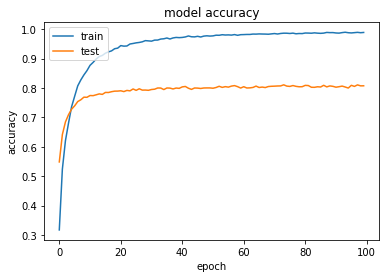

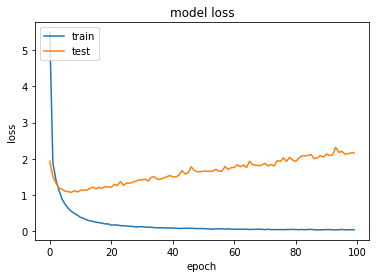

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

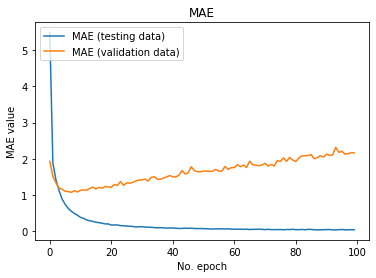

In [23]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

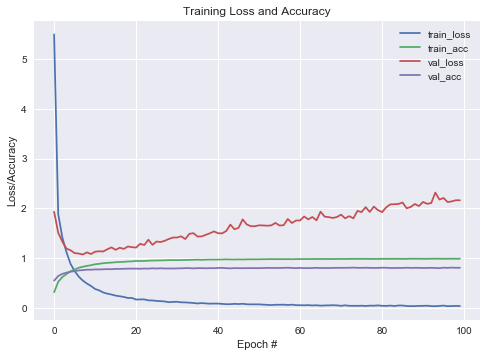

In [24]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochResNet101V2.png')
plt.close()